## Build model of movie watchers and movies:

Lets see how collaborative filtering can be used to create a model of movies and imdb users using fastai. We further show the results using dimensional reduction and further apply clustering to extract movie genres. We do this without explicit reference to movie labels.

In [1]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})

### Start by importing sample of imdb movie dataset using fastai.

In [2]:
from fastai.collab import untar_data, URLs

path = untar_data(URLs.ML_100k)
print('The data is here: ', path)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])

# The file has weird encoding but pandas provides a way of changing it.
items = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                    names=['movie', 'title', 'release date', 'video release date', 'IMDb URL', 
                           'unknown', 'Action', 'Adventure', 'Animation', "Children's", 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                           'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

ratings.head()

The data is here:  /home/topi/.fastai/data/ml-100k


,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
df = pd.merge(ratings, items, on='movie').drop(columns=['timestamp'])
df.user -= 1
df.movie -= 1

df.sort_values('user').head(10)

,user,movie,rating,title,release date,video release date,IMDb URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
43606,0,11,5,"Usual Suspects, The (1995)",14-Aug-1995,NaN,"http://us.imdb.com/M/title-exact?Usual%20Suspects,%20The%20(1995)",0,0,0,...,0,0,0,0,0,0,0,1,0,0
79998,0,253,1,Batman & Robin (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Batman+%26+Robin+(1997),0,1,1,...,0,0,0,0,0,0,0,0,0,0
35906,0,188,3,"Grand Day Out, A (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Grand%20Day%20Out,%20A%20(1992)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
69127,0,86,5,Searching for Bobby Fischer (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Searching%20for%20Bobby%20Fischer%20(1993),0,0,0,...,0,0,0,0,0,0,0,0,0,0
51383,0,186,4,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,"http://us.imdb.com/M/title-exact?Godfather:%20Part%20II,%20The%20(1974)",0,1,0,...,0,0,0,0,0,0,0,0,0,0
71026,0,179,3,Apocalypse Now (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Apocalypse%20Now%20(1979),0,0,0,...,0,0,0,0,0,0,0,0,1,0
97387,0,45,4,Exotica (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Exotica%20(1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
6611,0,200,3,Evil Dead II (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Evil%20Dead%20II%20(1987),0,1,1,...,0,0,1,0,0,0,0,0,0,0
36126,0,63,5,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Shawshank%20Redemption,%20The%20(1994)",0,0,0,...,0,0,0,0,0,0,0,0,0,0
6751,0,240,4,"Last of the Mohicans, The (1992)",01-Jan-1992,NaN,"http://us.imdb.com/M/title-exact?Last%20of%20the%20Mohicans,%20The%20(1992)",0,1,0,...,0,0,0,0,0,1,0,0,1,0


Each movie rated by a user is a single row in the dataframe. Then one can check how many movies each user has rated and plot a histogram:

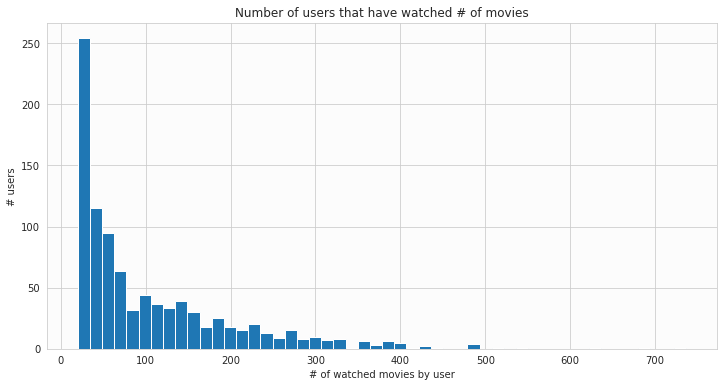

In [5]:
ax = df.loc[:, 'user'].value_counts().hist(bins=50)
ax.set_title('Number of users that have watched # of movies')
ax.set_xlabel('# of watched movies by user')
_ = ax.set_ylabel('# users')

Similarly we can chec the most popular movies:

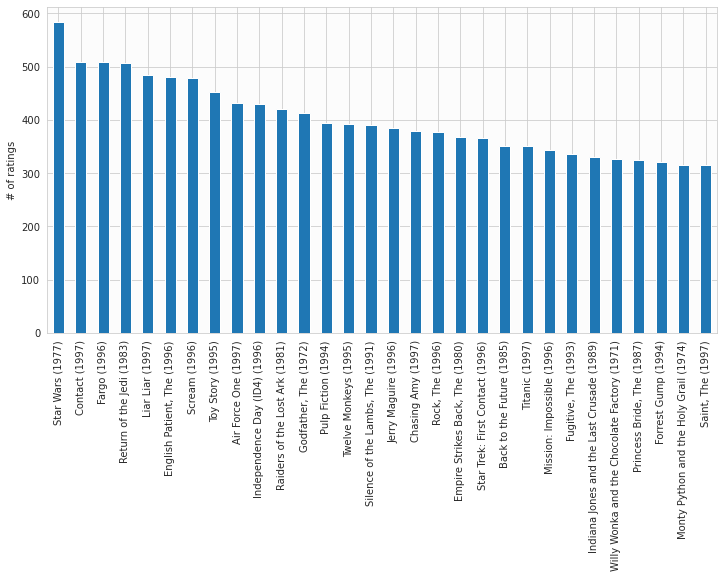

In [6]:
ax = df.loc[:, 'title'].value_counts().iloc[:30].plot.bar()
_ = ax.set_ylabel('# of ratings')

The rating of movies:

<AxesSubplot:xlabel='title'>

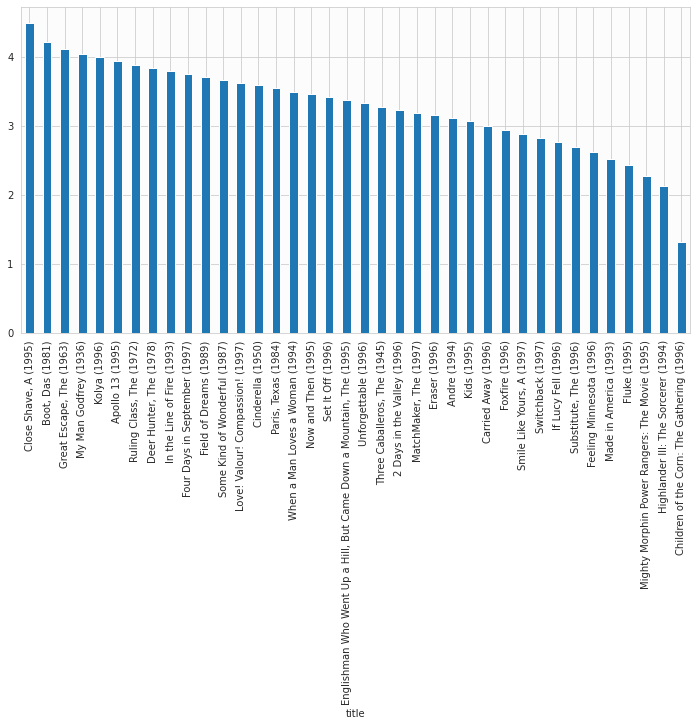

In [7]:
# First only pick movies which have more than 10 ratings:
tmp_ser = df.loc[:, 'movie'].value_counts() 
tmp_movies = tmp_ser.loc[tmp_ser > 10].index
mask = df.loc[:, 'movie'].isin(tmp_movies)

tmp_avg_rating = df.loc[mask].groupby('title').mean().loc[:, 'rating'].sort_values(ascending=False)[::30]
tmp_avg_rating.plot.bar()

### Lets build a training and validation sets.

In [8]:
# From each user pick a random movie - but make sure that movie reamins in train set as well:
valid_idxs = []
for u in df.user.unique():
    mask = u == df.user
    trial_idx = df.index[mask][3]
    valid_idxs.append(trial_idx)

    
df_valid = df.loc[np.array(valid_idxs), :].copy()
df_train = df.loc[~df.index.isin(np.array(valid_idxs)), :].copy()
df_train.shape, df_valid.shape

((99057, 26), (943, 26))

#### Lets pick the N most popular movies and M most active users:

In [9]:
nusers = 20
nmovies = 10
users = df_train.loc[:, 'user'].value_counts().iloc[:nusers].index
titles = df_train.loc[:, 'title'].value_counts().iloc[:nmovies].index
df_filtered = df_train.loc[df_train.user.isin(users) & df_train.title.isin(titles), :]

pd.pivot_table(df_filtered, index='user', columns='title', values='rating')

title,Air Force One (1997),Contact (1997),"English Patient, The (1996)",Fargo (1996),Independence Day (ID4) (1996),Liar Liar (1997),Raiders of the Lost Ark (1981),Return of the Jedi (1983),Scream (1996),Star Wars (1977)
user,,,,,,,,,,
6,4.0,4.0,4.0,5.0,5.0,1.0,5.0,3.0,4.0,5.0
12,1.0,4.0,3.0,5.0,5.0,2.0,4.0,5.0,1.0,5.0
91,NaN,4.0,NaN,5.0,5.0,3.0,5.0,4.0,3.0,5.0
93,NaN,5.0,4.0,5.0,2.0,NaN,4.0,4.0,3.0,5.0
180,3.0,3.0,1.0,3.0,4.0,2.0,NaN,NaN,4.0,NaN
233,3.0,2.0,3.0,4.0,NaN,3.0,3.0,3.0,3.0,4.0
275,4.0,5.0,NaN,5.0,4.0,4.0,5.0,5.0,4.0,5.0
278,NaN,NaN,NaN,4.0,4.0,2.0,4.0,3.0,3.0,3.0
292,2.0,3.0,3.0,4.0,3.0,2.0,5.0,3.0,3.0,5.0


## Task: find a way to predict a score user would give to a movie they have not seen (i.e., fill the nans)

Let us assume that each user can be described by a set of numbers $[f_{1i}, ... f_{Ni}]$, where $f_{ji}$ is the *latent factor* $j$ of user $i$. Furthermore assume similarly that a movie can be labeled by some other latent factors $[g_{1k},\ldots,g_{Mk}]$, where $g_{jk}$ is the *latent factor* $j$ of movie $k$. 

These latent factors could be viewed as, say preferences of a single user, and some properties (like genre) of a movie. Lets consider example user $U$ that strongly prefers western movies from the 70:ies over anything else, not bad taste! Lets denote for this user:

$\mathbf{f}_U = [f_{\text{western}}, f_{\text{70:ies}}, f_\text{scifi}] = [2, 2, 0]$,

Moreover, let us label our example movie $M$ by the same latent factors. We shall further assume that the example movies is "The good, the bad, and the ugly (1966)", then, 

$\mathbf{g}_M = [g_{\text{western}}, g_{\text{70:ies}}, g_\text{scifi}] = [1, .8, 0]$.

What would be the score given by user $U$ to movie $M$? We can figure out whatever, way of combining the above numbers but the simplest one is to take the innner product:

$R_{UM} = \mathbf{f}_U \cdot \mathbf{g}_M = \sum_i f_i g_i = 2*1 + 2*.8 + 0*0 = 3.6$.

Let us now assume that each number in the above pivot table is a result of such scoring given by some *latent factors* of the movies and users. Let us then use pytorch to figure out the latent factors.

In [10]:
a = np.linspace(1,9,9).reshape(3,3)
b = np.linspace(9, 17, 9).reshape(3,3)

a, b, a*b, (a*b).sum(axis=1)

(array([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]]),
 array([[ 9., 10., 11.],
        [12., 13., 14.],
        [15., 16., 17.]]),
 array([[  9.,  20.,  33.],
        [ 48.,  65.,  84.],
        [105., 128., 153.]]),
 array([ 62., 197., 386.]))

### (RMS) Loss:

In [13]:
from utils.dotbase import DotBase
        
        
class DotProductScore(DotBase):
    
    def __init__(self, users_shape, movies_shape, X, use_bias=False, lr=.1):
        
        super().__init__(users_shape, movies_shape, X, use_bias, lr)
        
        
    def get_loss(self, X=None):
        """
        Define a loss for your prediction. We know the true ratings given
        by users are stored in self.x[:, 2].
        """
        
        if X is None:
            X = self.x
        
        pred_rating = self.get_prediction(X[:, :2])
        return ((pred_rating - X[:, 2].flatten())**2).mean()
    
    def get_prediction(self, users_movies):
        """
        Use latent factors to produce a prediction of rating for given users and movies.
        """
        lat_users = self.lat_users[users_movies[:, 0]]
        lat_movies = self.lat_movies[users_movies[:, 1]]
        dot_product = (lat_users*lat_movies).sum(dim=1)
        if self.use_bias:
            score =  dot_product \
                        + self.bias_movies[users_movies[:, 1]] \
                        + self.bias_users[users_movies[:, 0]]
        else:
            score = dot_product
            
        return score

In [37]:
import torch 

nlatent = 2
nusers = df.user.nunique()
nmovies = df.movie.nunique()

use_bias = True
nepochs=100
cols = ['user', 'movie', 'rating']

X = torch.tensor(df_train.loc[:, cols].values)
dps = DotProductScore((nusers, nlatent), (nmovies, nlatent), X, use_bias, lr=.1)


for i in range(nepochs):
    loss = dps.update_lat()
    if i%(nepochs//10) == 0:
        print('Epoch {}:'.format(i), loss.data, dps.get_loss(torch.tensor(df_valid.loc[:, cols].values)).data)
        dps.save()


Epoch 0: tensor(0.5299) tensor(0.8614)
Epoch 10: tensor(0.5073) tensor(0.8597)
Epoch 20: tensor(0.4876) tensor(0.8584)
Epoch 30: tensor(0.4704) tensor(0.8575)
Epoch 40: tensor(0.4552) tensor(0.8568)
Epoch 50: tensor(0.4416) tensor(0.8563)
Epoch 60: tensor(0.4294) tensor(0.8561)
Epoch 70: tensor(0.4183) tensor(0.8560)
Epoch 80: tensor(0.4083) tensor(0.8561)
Epoch 90: tensor(0.3992) tensor(0.8563)


In [40]:
df_train.loc[:, 'user_biases'] = dps.get_params(df_train.user.values)[1].detach().numpy()
df_train.loc[:, 'movie_biases'] = dps.get_params(df_train.movie.values, key='movie')[1].detach().numpy()

movie_title_df = df_train.drop_duplicates(subset=['movie']).set_index('movie').sort_index()
# Add the count the movie is present in training set:
movie_title_df.loc[:, 'count'] = df_train.value_counts('movie').sort_index()
# add the mean rating of each movie:
movie_title_df.loc[:, 'avg_rating'] = [df_train.loc[df_train.loc[:, 'movie'] == mv, 'rating'].mean() for mv in movie_title_df.index]


movie_title_df.loc[:, ['title', 'movie_biases', 'count', 'avg_rating']].sort_values('movie_biases', ascending=False)[:15]

,title,movie_biases,count,avg_rating
movie,,,,
1448,Pather Panchali (1955),2.809801,8,4.625000
317,Schindler's List (1993),2.579893,298,4.466443
63,"Shawshank Redemption, The (1994)",2.560149,283,4.445230
168,"Wrong Trousers, The (1993)",2.526088,118,4.466102
482,Casablanca (1942),2.503589,242,4.454545
407,"Close Shave, A (1995)",2.503522,112,4.491071
113,Wallace & Gromit: The Best of Aardman Animation (1996),2.440399,67,4.447761
602,Rear Window (1954),2.434463,201,4.388060
11,"Usual Suspects, The (1995)",2.422021,267,4.385768


### Worst movies:

In [41]:
movie_title_df.loc[:, ['title', 'movie_biases', 'count', 'avg_rating']].sort_values('movie_biases')[:15]

,title,movie_biases,count,avg_rating
movie,,,,
1620,Butterfly Kiss (1995),-0.736343,1,1.000000
598,Police Story 4: Project S (Chao ji ji hua) (1993),-0.727613,1,1.000000
1501,Naked in New York (1994),-0.717546,2,1.500000
436,Amityville 1992: It's About Time (1992),-0.641287,5,1.000000
438,Amityville: A New Generation (1993),-0.636107,5,1.000000
246,Turbo: A Power Rangers Movie (1997),-0.548483,5,1.800000
757,Lawnmower Man 2: Beyond Cyberspace (1996),-0.506195,21,1.714286
1617,King of New York (1990),-0.481698,1,1.000000
1660,"New Age, The (1994)",-0.481429,1,1.000000


In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

lat_movie = np.hstack((dps.get_params(movie_title_df.index, key='movie')[0].detach().numpy(), 
                       dps.get_params(movie_title_df.index, key='movie')[1].detach().numpy().reshape(-1, 1)))


lat_movie_pca = PCA(n_components=2).fit_transform(lat_movie)
lat_movie_tsne = TSNE(n_components=2).fit_transform(lat_movie)

In [17]:
N = 20
popular_movies = df_train.loc[:, 'movie'].value_counts().iloc[:N].index
good_movies = movie_title_df.sort_values('movie_biases', ascending=False).iloc[:N].index

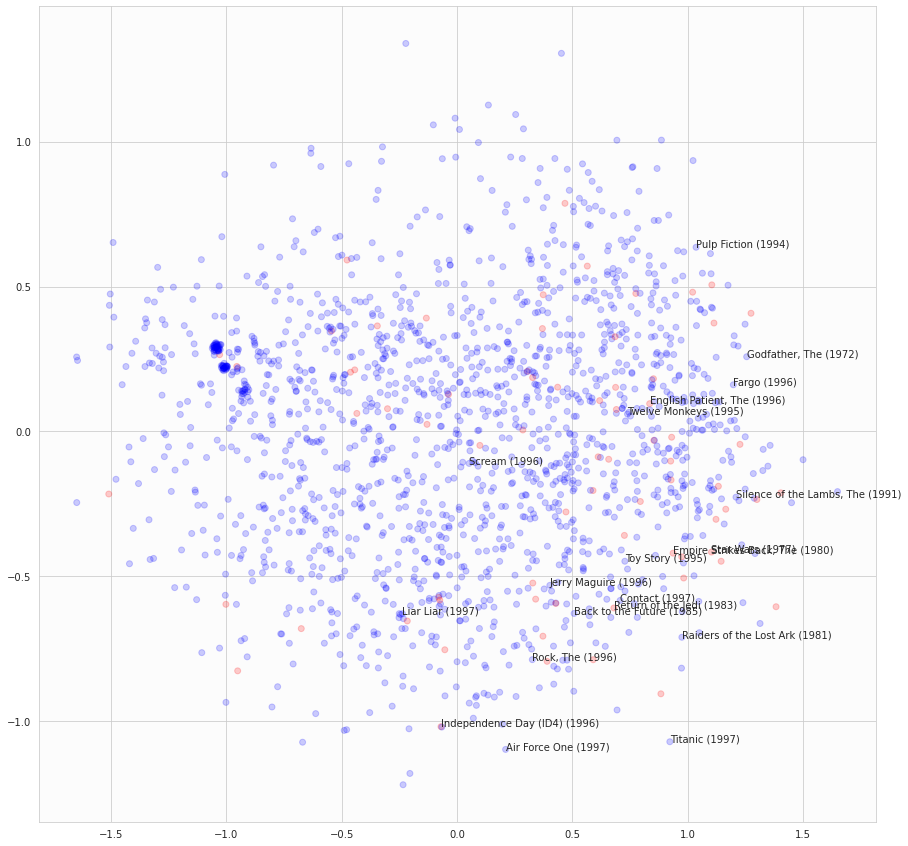

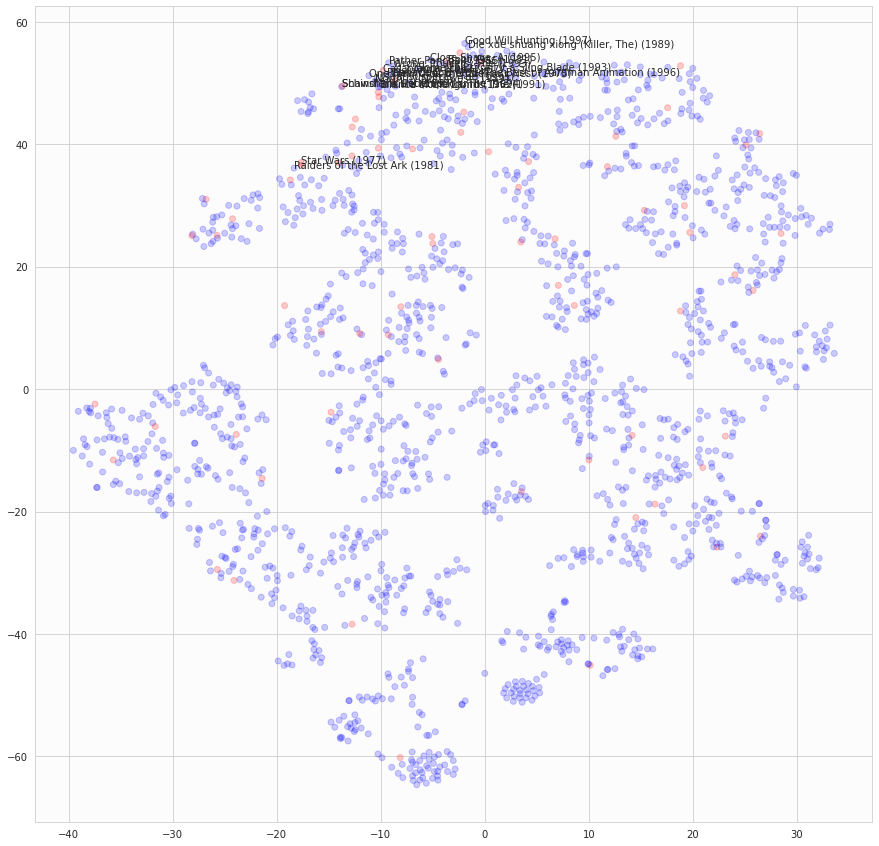

In [18]:
def plot_movies(movie_2d, idxs, named_movies, colors=None, alpha=.2):
    
    plt.subplots(figsize=(15,15))
    
    plt.scatter(movie_2d[idxs, 0], movie_2d[idxs, 1], c=colors, alpha=alpha)
    for idx in named_movies:
        plt.annotate(movie_title_df.loc[idx, 'title'], xy=(movie_2d[idx, :]))
    plt.show()
    
idxs = movie_title_df.index
colors = np.array(['blue']*len(idxs), dtype=object)
colors[movie_title_df.loc[idxs, 'War'].astype(bool)] = 'red'
    
plot_movies(lat_movie_pca, idxs, popular_movies, colors)
#plot_movies(lat_movie_tsne, idxs, popular_movies, colors)
plot_movies(lat_movie_tsne, idxs, good_movies, colors)

### Cluster in the tsne: 

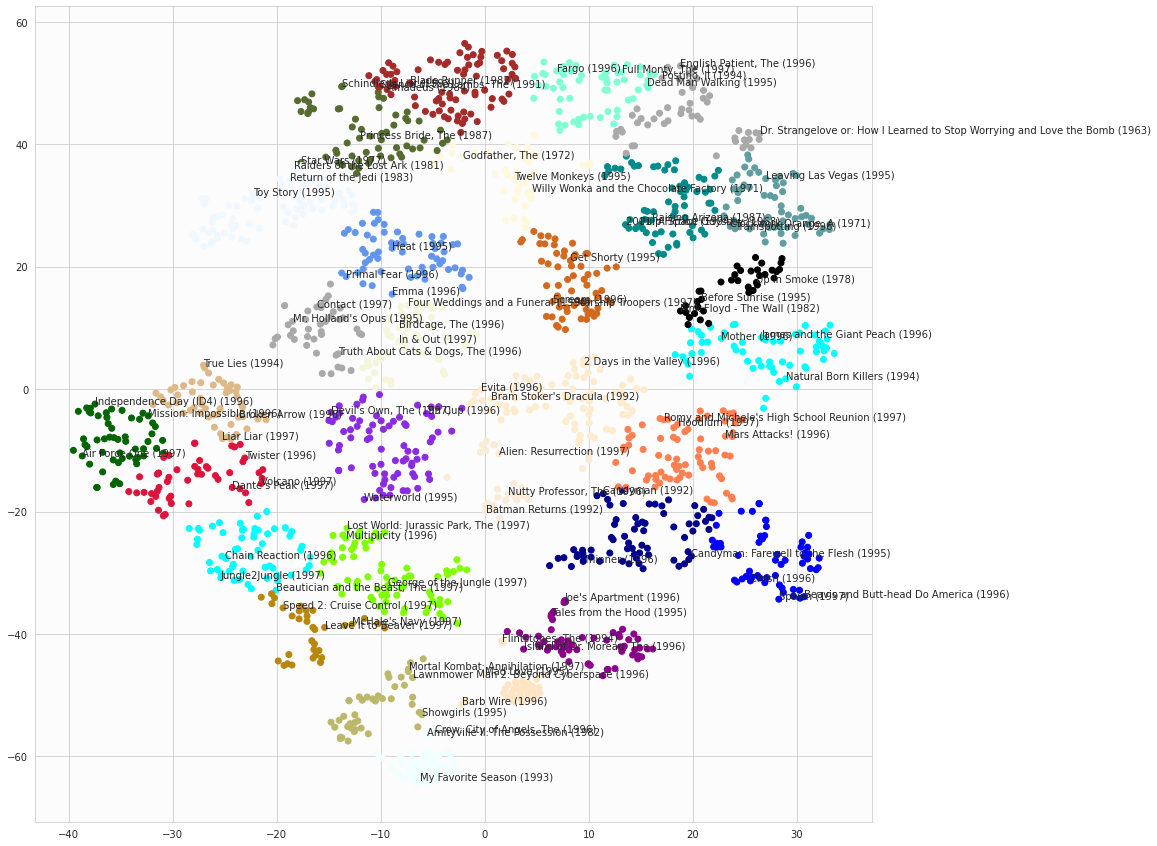

In [33]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.colors as mcolors

colors_dict = {i:v for i, (k,v) in enumerate(mcolors.CSS4_COLORS.items())}
colors_dict[-1] = 'red'
n_clusters=30

def get_clusters(cl, X, print_report=False):
    
    cl.fit(X, None)
    colors = [colors_dict[i] for i in cl.labels_]
    cl_movies = []
    
    # Loop over every cluster
    for cl_idx in np.unique(cl.labels_):
        # Make a movie_df mask that can pick up the current cluster in the movie_title_df:
        mask = cl_idx == cl.labels_
        
        # Use the train set df to get the popularity of each movie in current cluster:
        cluster_df = movie_title_df.loc[mask, ['title', 'count', 'avg_rating']].sort_values('count', ascending=False)[:3]
        
        if print_report:
            print('Cluster: {}'.format(cl_idx))
            display(cluster_df)
            print()

        # Pick the 3 most popular movies:
        cl_movies.append(cluster_df.index)
        
    return np.array(np.hstack(cl_movies)).flatten(), colors

X = lat_movie_tsne
cl_movies, colors = get_clusters(KMeans(n_clusters), X)
plot_movies(X, idxs, cl_movies, colors, alpha=1)

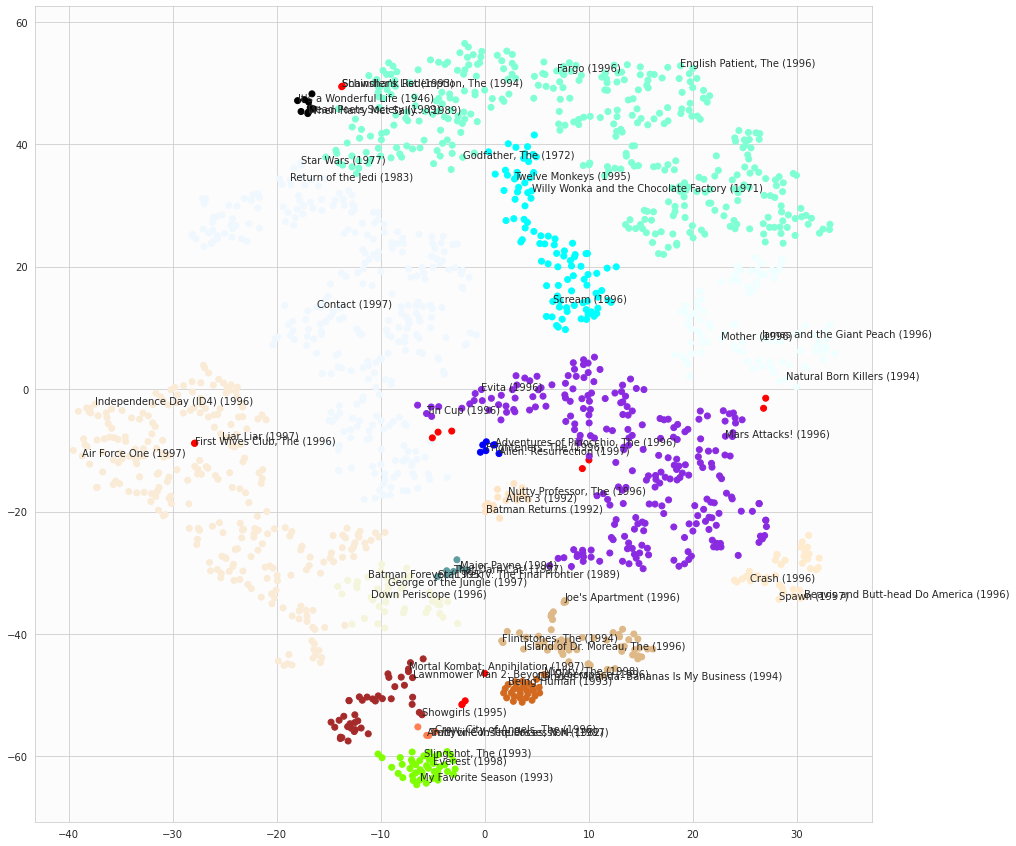

In [29]:
cl_movies, colors = get_clusters(DBSCAN(eps=2.5), X)
plot_movies(X, idxs, cl_movies, colors, alpha=1)

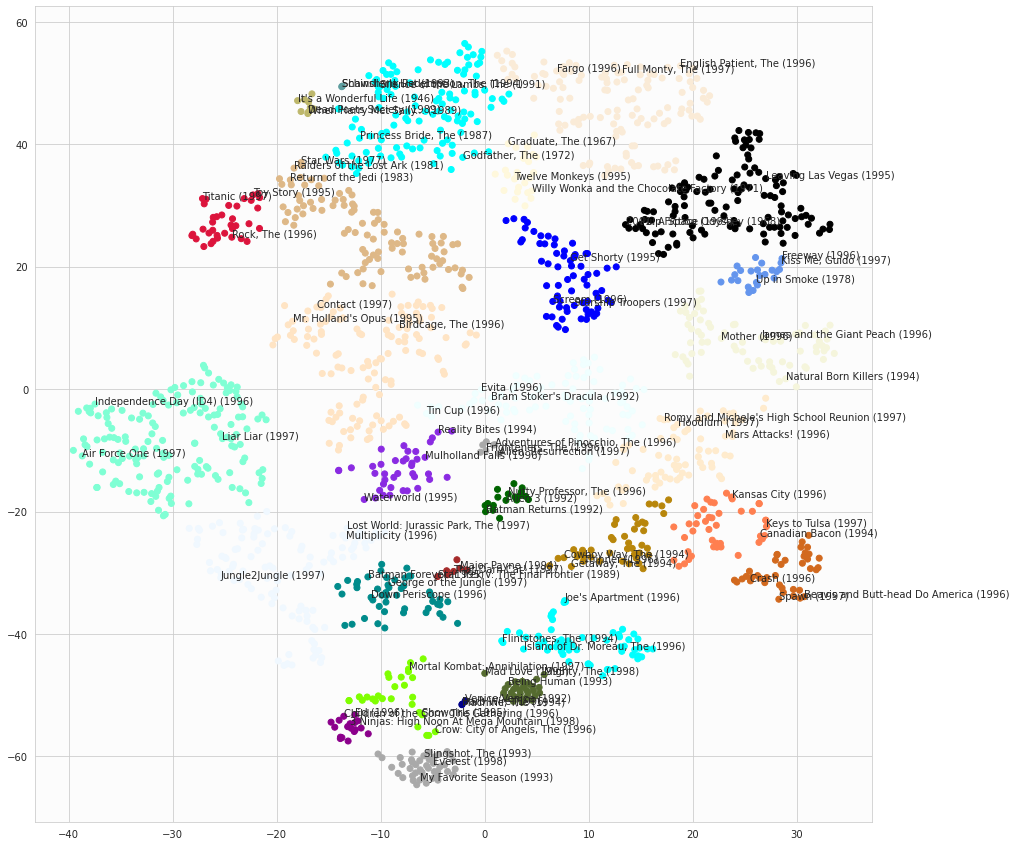

In [36]:
from sklearn.cluster import SpectralClustering

cl_movies, colors = get_clusters(SpectralClustering(n_clusters), X)
plot_movies(X, idxs, cl_movies, colors, alpha=1)

### Suggested exercises:
1. Modify the loss so that mis prediction on a popular title would be more serious than on a unpopular one.
2. Try to device a regularization that would push as many of the latent factors to zero as possible.
3. Why are 'good movies' so close to each other in the tsne mapping?
4. Explain how, KMeans and DBscan work.


## Collab filtering using fastai:

,user,title,rating
0,346,Tombstone (1993),5
1,69,"Wrong Trousers, The (1993)",4
2,475,Clueless (1995),3
3,431,Breakdown (1997),3
4,503,Murder at 1600 (1997),4
5,752,"Shawshank Redemption, The (1994)",4
6,69,Swingers (1996),3
7,789,Tombstone (1993),4
8,455,To Die For (1995),3
9,177,Die Hard (1988),4


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=9.12010818865383e-07)

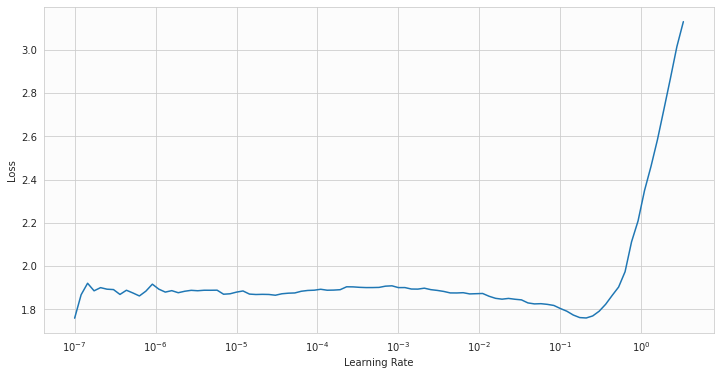

In [4]:
from fastai.collab import *
from fastai.tabular.all import *


dls = CollabDataLoaders.from_df(df.loc[:, ['user', 'title', 'rating']], item_name='title', bs=128)

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

dls.show_batch()

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.lr_find()

In [23]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,time
0,1.134513,1.050727,00:02
1,0.865588,0.892121,00:02
2,0.793644,0.854619,00:02
3,0.730213,0.842185,00:02
4,0.702786,0.840796,00:02


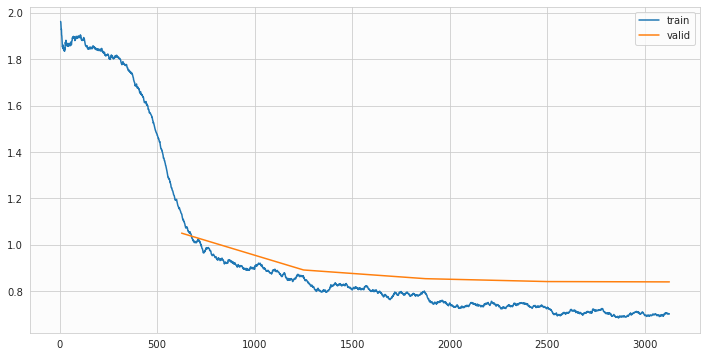

In [24]:
learn.recorder.plot_loss()

In [25]:
learn.fit_one_cycle(5, 2e-3, wd=.1)

epoch,train_loss,valid_loss,time
0,0.713556,0.844325,00:02
1,0.691117,0.830535,00:02
2,0.624505,0.826685,00:02
3,0.552221,0.827289,00:02
4,0.505210,0.827383,00:02


In [32]:
movie_bias = learn.model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[(movie_bias[i], dls.classes['title'][i]) for i in idxs]

[(tensor(0.4877, device='cuda:0', grad_fn=<SelectBackward>), 'Titanic (1997)'),
 (tensor(0.4341, device='cuda:0', grad_fn=<SelectBackward>),
  "Schindler's List (1993)"),
 (tensor(0.4202, device='cuda:0', grad_fn=<SelectBackward>),
  'L.A. Confidential (1997)'),
 (tensor(0.4192, device='cuda:0', grad_fn=<SelectBackward>),
  'Shawshank Redemption, The (1994)'),
 (tensor(0.3998, device='cuda:0', grad_fn=<SelectBackward>),
  'Good Will Hunting (1997)')]